# Python and Dask<br>Scaling the DataFrame

# Getting started with Dask

## Training overview

* An introduction to Dask focused on tabular data.
* We will not cover all of Dask or all the APIs
* Assuming that participants have an intermediate level of experience with Pandas

## Overview by lesson
TODO: Fill in with lesson information

* Lesson 1
* Lesson 2
* Lesson 3

## Lesson Outline

* Course Setup
* 10 Minutes to Dask
* Why Dask?
* Dask APIs

## Setup for the course

You'll need to have `miniconda3` or `anaconda3` installed.

Clone the `git` repo for this course.

```bash
$ git clone -–depth 1 https://github.com/dgerlanc/dask-scaling-dataframe.git
```

Install the environment:

```bash
$ conda env create -f binder/environment.yml
```

This may take a minute or so (depends on the speed of your internet connection).

```bash
$ conda activate scale-df
```

You may also run using Binder, though you may need be more successful using the threaded scheduler.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dgerlanc/dask-scaling-dataframe/master?urlpath=lab)

## 10 minutes to Dask

* Use the Dask Dataframe API
* View the task graph
* View the distributed dashboard

In [1]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:51130 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


Click on the link for the `Dashboard` to see the distributed dashboard

## Simple setup

* Using the `distributed` scheduler
* We'll discuss scheduler options later
* Creating a `Client` starts a cluster on your local machine

In [2]:
import pandas as pd
import dask.dataframe as dd

Manually set the types here to minimize memory usage

In [3]:
pay_dtypes = {
    'fiscal_year': 'Int16',
    'payroll_number': None,
    'agency_name': 'category',
    'last_name': None,
    'first_name': None,
    'mid_init': None,
    'agency_start_date': object,
    'work_location_borough': 'category',
    'title_description': 'category',
    'leave_status_as_of_june_30': 'category',
    'base_salary': 'float64',
    'pay_basis': 'category',
    'regular_hours': 'float64',
    'regular_gross_paid': 'float64',
    'ot_hours': 'float64',
    'total_ot_paid': 'float64',
    'total_other_pay': 'float64',
    }

date_cols = ['agency_start_date']

all_cols = list(k for k,v in pay_dtypes.items() if v is not None)

In [4]:
pay = dd.read_csv(
    'data/nyc_payroll.csv', 
    dtype=pay_dtypes,
    usecols=all_cols
)

Dask read_csv mostly follows the `pandas` options.

To see all the arguments to `dd.read_csv`, use documentation for `pd.read_csv`

In [ ]:
# ?pd.read_csv

In [ ]:
# dat = pd.read_csv('nyc_payroll.csv', low_memory=False)
# cols = [x.lower().replace(' ', '_') for x in list(dat.columns)]
# dat.columns = cols
# dat.to_csv('nyc_payroll.csv', index=False)

In [5]:
pay.dtypes

fiscal_year                      Int16
agency_name                   category
agency_start_date               object
work_location_borough         category
title_description             category
leave_status_as_of_june_30    category
base_salary                    float64
pay_basis                     category
regular_hours                  float64
regular_gross_paid             float64
ot_hours                       float64
total_ot_paid                  float64
total_other_pay                float64
dtype: object

In [6]:
pay.head()

,fiscal_year,agency_name,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay
0,2016,DISTRICT ATTORNEY-MANHATTAN,07/14/2003,MANHATTAN,COMMUNITY ASSOCIATE,ACTIVE,47678.0,per Annum,1830.00,47166.03,2.25,57.28,0.0
1,2016,DISTRICT ATTORNEY-MANHATTAN,06/12/1995,MANHATTAN,ADMINISTRATIVE ACCOUNTANT,ACTIVE,119959.0,per Annum,1831.00,119042.50,0.00,0.00,0.0
2,2016,DISTRICT ATTORNEY-MANHATTAN,10/11/2011,MANHATTAN,COMMUNITY ASSOCIATE,ON LEAVE,39966.0,per Annum,1181.68,27452.62,1.00,21.34,33.0
3,2016,DISTRICT ATTORNEY-MANHATTAN,12/01/2014,MANHATTAN,COMPUTER SYSTEMS MANAGER,ACTIVE,116000.0,per Annum,1831.00,115104.57,0.00,0.00,0.0
4,2016,DISTRICT ATTORNEY-MANHATTAN,05/21/2015,MANHATTAN,COLLEGE AIDE,CEASED,1.0,per Hour,0.00,3500.00,0.00,0.00,0.0


Don't seem to have any differences from Pandas yet...

## Partitioned Pandas

Dask DataFrames are made up of one or more Pandas DataFrames aligned along a single axis.

<img src="images/dask-dataframe.svg" width=250>

This [illustration](https://docs.dask.org/en/latest/_images/dask-dataframe.svg) (c) 2014-2018, Inc. and contributors.

## Dask operates on DAGs

Dask creates a task graph that has not yet been executed. Here we'll be able to see the partitioning in action.

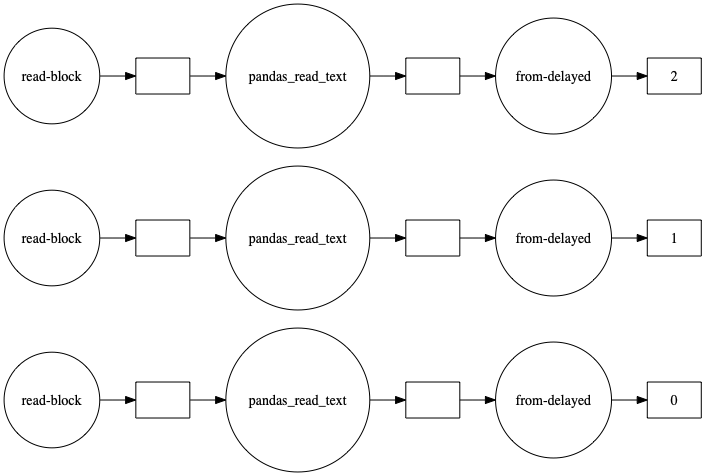

In [22]:
pay3 = dd.read_csv(
    'data/nyc_payroll.csv', 
    dtype=pay_dtypes,
    usecols=all_cols,
    blocksize='200MB'
)

pay3.visualize(rankdir="LR")

In [24]:
pay3.npartitions

3

## Setting the number of tasks

Number of partitions is based on the number of files and the size of each file.

In [ ]:
dd.read_csv(
    'data/nyc_payroll.csv', 
    dtype=pay_dtypes,
    usecols=all_cols,
    blocksize=500_000
).npartitions

## Graph to computation

In [26]:
# returns a delayed operation
pay['base_salary'].max()

dask.dataframe.core.Scalar

In [27]:
# call compute to evaluate it
%time pay['base_salary'].max().compute()

CPU times: user 123 ms, sys: 18.2 ms, total: 141 ms
Wall time: 2.82 s


352763.0

In [1]:
pay = pay.persist()

NameError: name 'pay' is not defined

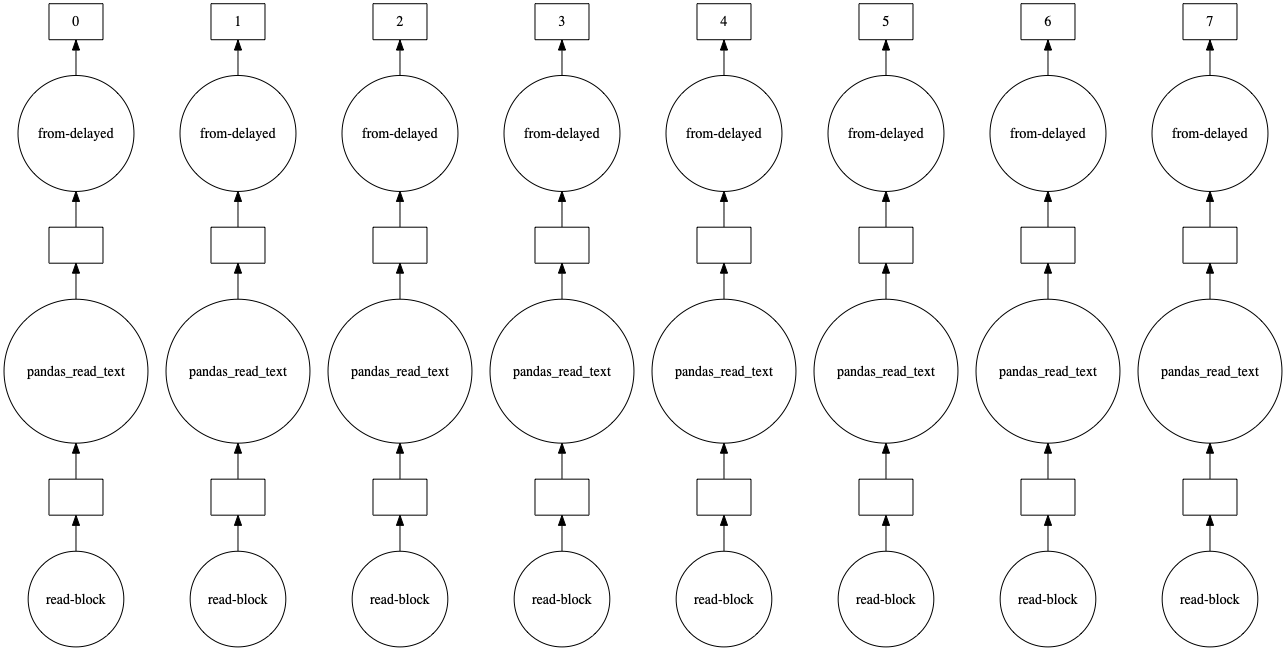

In [29]:
pay.visualize()

In [ ]:
%time pay['base_salary'].max().compute()

## Compare to using base `pandas`

In [ ]:
%%time

pay_pd = pd.read_csv(
    'data/nyc_payroll.csv', 
    dtype=pay_dtypes,
    usecols=all_cols,
)
pay_pd['base_salary'].max()

Once data is in memory, distributed solution is slower

In [ ]:
%time pay_pd['base_salary'].max()

In [ ]:
%time pay['base_salary'].max().compute()

## Dask Distributed Dashboard

In [ ]:
client

In [ ]:
grp = pay.groupby('work_location_borough')

In [ ]:
grp['base_salary'].agg(['mean', 'size']).compute()

# Why Dask?

### Python all the way down...

* Framework for parallel/distributed computing written in pure Python
* If you're already using Python, just add another package
* Integrates with existing Python environment, e.g. `numpy`, `pandas`, `sklearn`

### From laptop to cluster

* One line to start using on your laptop
* Scripts to deploy to HPC, YARN, Kubernetes, a bunch of instances over SSH...

## When to use dask

__Your problem:__

* does not fit in memory
* may be sped up though parallelism (single or multi-machine)
* custom computations that don't fit into map/filter/reduce framework

## When to not use Dask

“Parallelism and distributed computing are expensive ways to accelerate your application.”

Dask Documentation

* Does your data (easily) fit into RAM?
* Can you use profile and rewrite the slow parts in a compiled language? (or use `numba`)

# Dask APIs

“We will encourage you to develop the three great virtues of a programmer: 
laziness, impatience, and hubris.”

Larry Wall - _Programming Perl_

### High Level

* DataFrame (pandas)
* Array (like numpy)
* Bag (like pytoolz)

### Lower Level

* Delayed (Sync)
* Futures (Async)

## We're going to focus on DataFrame and Delayed

Delayed is the building-block of Dask.

In [ ]:
# psmall = dd.read_parquet('data/jobs.parquet')


In [ ]:
pay.fiscal_year.unique().compute()

In [ ]:
client.close()

## Dask operates out-of-memory by default

* Allows us to operate datasets that don't fit into memory without explicit chunking/streaming
* However, once we've run, data not persisted
* Need to reread the data from disk

TODO: Add slide here

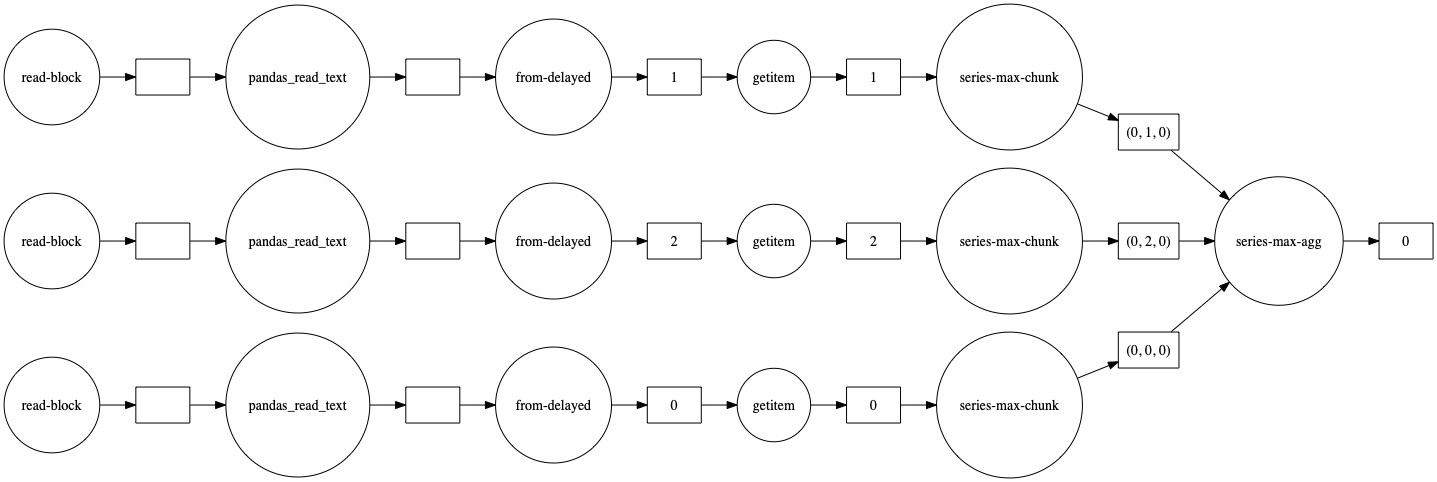

In [30]:
pay3['base_salary'].max().visualize(rankdir='LR')